# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import time
from unityagents import UnityEnvironment
import numpy as np

# Record the start time
start_time = time.time()

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
exe_path = 'Tennis_Windows_x86_64/Tennis.app'
env = UnityEnvironment(file_name=exe_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0


### 4. Train the Agent with DDPG

Train the agent by running the code cells below! Objective of the training is to achieve an average score of 30 for the last 100 consecutive episodes. Once this is achieved the agent will be saved as a solution_actor.pth and a solution_critic.pth.
Below are the tuning parameters used to achieve these results:
```python
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay
```

In [6]:
from collections import deque
from ddpg_agent import Agent
import matplotlib.pyplot as plt
import torch

In [7]:
# Define function for training using DDPG agent with reacher environments
def ddpg(n_episodes=5000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                 # get the current state (for each agent)
        agent.reset()
        score = np.zeros(num_agents)                          # initialize the score (for each agent)

        for t in range(max_t):
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            score += rewards                                   # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones) # update the agent
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        # Compute mean score
        mean_score = np.mean(score)
        scores_deque.append(mean_score)
        scores.append(mean_score)
        # Print out performance after each episode
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        # Permanently print out average and save agent checkpoint every 100 episodes
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))   
        # Print out number of episodes required to achieve target score and save agent solution
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes.'.format(i_episode))
            torch.save(agent.actor_local.state_dict(), 'solution_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'solution_critic.pth')
            break
    return scores

c:\Users\lench\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 500	Average Score: -0.00
Episode 600	Average Score: -0.00
Episode 700	Average Score: -0.00
Episode 800	Average Score: -0.00
Episode 900	Average Score: -0.00
Episode 1000	Average Score: -0.00
Episode 1100	Average Score: -0.00
Episode 1200	Average Score: -0.00
Episode 1300	Average Score: -0.00
Episode 1400	Average Score: -0.00
Episode 1500	Average Score: -0.00
Episode 1600	Average Score: -0.00
Episode 1700	Average Score: -0.00
Episode 1800	Average Score: -0.00
Episode 1900	Average Score: -0.00
Episode 2000	Average Score: 0.00
Episode 2100	Average Score: 0.00
Episode 2200	Average Score: 0.00
Episode 2300	Average Score: 0.01
Episode 2400	Average Score: 0.01
Episode 2500	Average Score: 0.02
Episode 2600	Average Score: 0.02
Episode 2700	Average Score: 0.04
Episode 2800	Average Score: 0.04
Episode 2894	Average Score: 0.50
Environment solved in 2894 episod

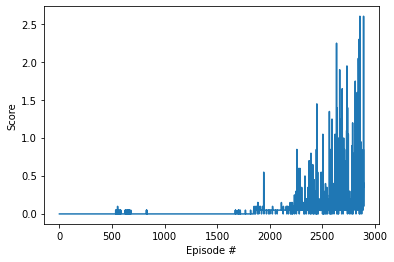

In [8]:
# Initialize DDPG agent and train agent
agent = Agent(num_agents=num_agents, state_size=states.shape[1], action_size=brain.vector_action_space_size, random_seed=10)
scores = ddpg()

# Plot Score vs Episode from training data
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('tennis_training.png')
plt.show()

### 4. Test the Agent

Test the agent by running the code cells below! Objective of the testing is to ensure the agent can achieve an average score of 30 over 100 consecutive episodes. The plot produced will show the training scores for each episode and a line representing the average over the 100 episodes.

In [9]:
# Define function for testing agent with reacher environments
def test(episodes=100):
    # Load agent solution
    agent.actor_local.load_state_dict(torch.load('solution_actor.pth'))
    agent.critic_local.load_state_dict(torch.load('solution_critic.pth'))

    scores = []

    for i_episode in range(1, episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = np.zeros(num_agents)                          # initialize the score (for each agent)

        while True:
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            score += rewards                                   # update the score (for each agent)
            states = next_states                               # roll over states to next time step

            if any(dones):
                break

        mean_score = np.mean(score)
        scores.append(mean_score)
        # Print out Score for each testing episode
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))

    # Compute the overall mean score from testing and print out resutls
    overall_mean = np.mean(scores)
    print('\nAverage Score {:.2f} Episodes: {:.2f}'.format(overall_mean, i_episode))
            
    return scores

c:\Users\lench\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: 0.35
Episode 2	Average Score: 0.10
Episode 3	Average Score: 0.20
Episode 4	Average Score: 2.60
Episode 5	Average Score: -0.00
Episode 6	Average Score: 0.25
Episode 7	Average Score: 0.35
Episode 8	Average Score: 2.45
Episode 9	Average Score: 0.70
Episode 10	Average Score: 0.25
Episode 11	Average Score: 2.60
Episode 12	Average Score: 0.35
Episode 13	Average Score: 0.25
Episode 14	Average Score: -0.00
Episode 15	Average Score: 0.15
Episode 16	Average Score: 2.60
Episode 17	Average Score: 0.50
Episode 18	Average Score: 0.55
Episode 19	Average Score: 0.10
Episode 20	Average Score: 0.90
Episode 21	Average Score: 2.60
Episode 22	Average Score: -0.00
Episode 23	Average Score: 0.35
Episode 24	Average Score: 0.15
Episode 25	Average Score: -0.00
Episode 26	Average Score: 0.25
Episode 27	Average Score: 0.20
Episode 28	Average Score: 0.15
Episode 29	Average Score: 0.20
Episode 30	Average Score: 1.65
Episode 31	Average Score: 0.95
Episode 32	Average Score: 0.20
Episode 33	Av

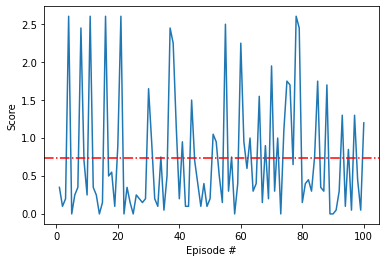

In [10]:
# Initialize DDPG agent and test agent
agent = Agent(num_agents=num_agents, state_size=states.shape[1], action_size=brain.vector_action_space_size, random_seed=10)
scores = test()

# Plot Score vs Episode for testing data with average score line
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.axhline(np.mean(scores), color='r', linestyle='-.', label='Mean Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
# Save the plot to a file
plt.savefig('tennis_testing.png')
plt.show()

In [11]:
# Close environment
env.close()

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time to run this notebook
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 7386.83 seconds
